# PART A

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct 
from skimage.metrics import peak_signal_noise_ratio
import time
import os

In [3]:
def display_image(image, title="Image", cmap=None):
    plt.figure(figsize=(6, 6))
    if cmap:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if len(image.shape) == 3 and image.shape[2] == 3 else image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [4]:
def dct2(block):
    return dct(dct(block.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(block):
    return idct(idct(block.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

Original image shape: (512, 512)


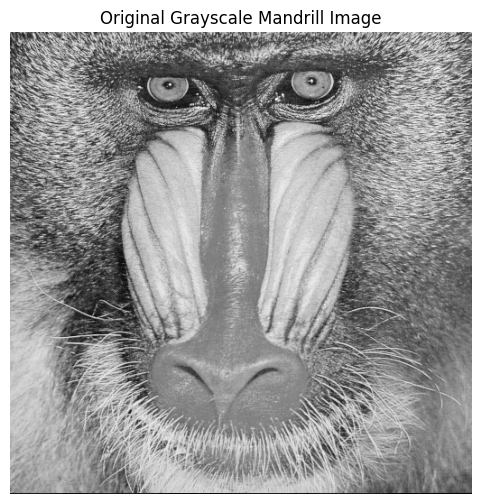

In [5]:
image_path = "mandril.tiff"

if not os.path.exists(image_path):
    print(f"Error in reading image")
    original_image_color = None
else:
    original_image_color = cv2.imread(image_path)

if original_image_color is None:
    print(f"Failed to load image")
else:
    original_image_gray = cv2.cvtColor(original_image_color, cv2.COLOR_BGR2GRAY)
    original_image_float = original_image_gray.astype(np.float32)
    
    print(f"Original image shape: {original_image_gray.shape}")
    display_image(original_image_gray, title="Original Grayscale Mandrill Image")

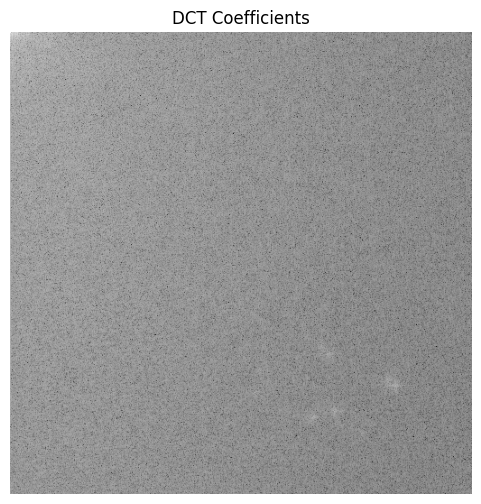

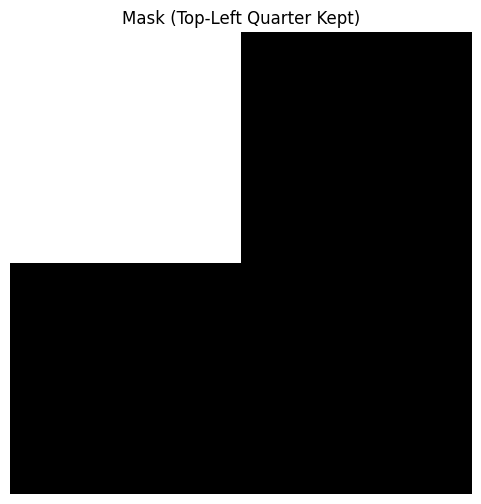

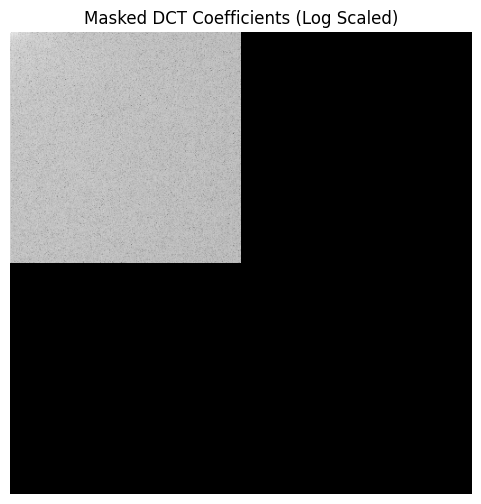

In [7]:
start_time = time.time()
dct_coeffs = dct2(original_image_float)

dct_coeffs_log_scaled = np.log(np.abs(dct_coeffs) + 1e-9)
display_image(dct_coeffs_log_scaled, title="DCT Coefficients")

rows, cols = dct_coeffs.shape
mask = np.zeros_like(dct_coeffs, dtype=np.float32)
    
mask_rows_quarter = rows // 2
mask_cols_quarter = cols // 2 
    
mask[0:mask_rows_quarter, 0:mask_cols_quarter] = 1.0
    
display_image(mask, title="Mask (Top-Left Quarter Kept)")

masked_dct_coeffs = dct_coeffs * mask
    
masked_dct_coeffs_log_scaled = np.log(np.abs(masked_dct_coeffs) + 1e-9)
display_image(masked_dct_coeffs_log_scaled, title="Masked DCT Coefficients (Log Scaled)")


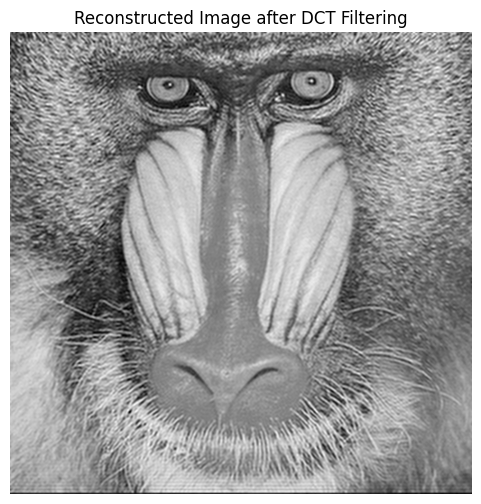

In [8]:
reconstructed_image_float = idct2(masked_dct_coeffs)
reconstructed_image = np.clip(reconstructed_image_float, 0, 255)
reconstructed_image = reconstructed_image.astype(np.uint8)    
end_time = time.time()
execution_time = end_time - start_time
display_image(reconstructed_image, title="Reconstructed Image after DCT Filtering")

In [9]:
if original_image_color is not None:

    psnr_value = peak_signal_noise_ratio(original_image_gray, reconstructed_image, data_range=255)

    print(f"\n--- Results ---")
    print(f"Original Image Dimensions: {original_image_gray.shape}")
    print(f"Reconstructed Image Dimensions: {reconstructed_image.shape}")
    print(f"Mask kept top-left {mask_rows_quarter}x{mask_cols_quarter} coefficients.")
    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"Total Execution Time (DCT, Masking, IDCT): {execution_time:.4f} seconds")


--- Results ---
Original Image Dimensions: (512, 512)
Reconstructed Image Dimensions: (512, 512)
Mask kept top-left 256x256 coefficients.
PSNR: 24.53 dB
Total Execution Time (DCT, Masking, IDCT): 3.7148 seconds


# PART B

In [10]:
def process_image_blockwise(image_to_process_float, original_img_gray_for_psnr, block_size_N):
    original_rows, original_cols = image_to_process_float.shape
    
    pad_rows_bottom = (block_size_N - original_rows % block_size_N) % block_size_N
    pad_cols_right = (block_size_N - original_cols % block_size_N) % block_size_N
    
    padded_image = np.pad(image_to_process_float, 
                          ((0, pad_rows_bottom), (0, pad_cols_right)), 
                          mode='reflect')

    padded_rows, padded_cols = padded_image.shape
    reconstructed_padded_image = np.zeros_like(padded_image, dtype=np.float32)
    
    mask_block = np.zeros((block_size_N, block_size_N), dtype=np.float32)
    keep_dim = block_size_N // 2  
    mask_block[0:keep_dim, 0:keep_dim] = 1.0
    

    start_time_proc = time.time()
    
    for r_idx in range(0, padded_rows, block_size_N):
        for c_idx in range(0, padded_cols, block_size_N):
            current_block = padded_image[r_idx : r_idx + block_size_N, c_idx : c_idx + block_size_N]
            
            block_dct_coeffs = dct2(current_block)
            
            masked_block_coeffs = block_dct_coeffs * mask_block
            
            reconstructed_block = idct2(masked_block_coeffs)
            
            reconstructed_padded_image[r_idx : r_idx + block_size_N, c_idx : c_idx + block_size_N] = reconstructed_block
            
    end_time_proc = time.time()
    execution_time_proc = end_time_proc - start_time_proc
    
    reconstructed_image_cropped_float = reconstructed_padded_image[0:original_rows, 0:original_cols]

    reconstructed_image_uint8 = np.clip(reconstructed_image_cropped_float, 0, 255).astype(np.uint8)

    psnr_value = peak_signal_noise_ratio(original_img_gray_for_psnr, reconstructed_image_uint8, data_range=255)
    
    return reconstructed_image_uint8, execution_time_proc, psnr_value

Starting block-wise DCT processing for different block sizes...

--- Processing with block size: 8x8 ---


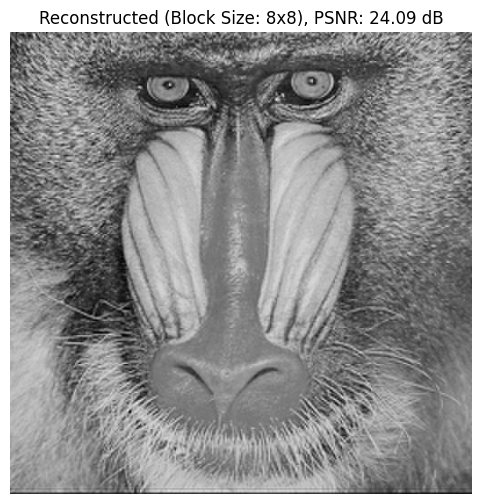

Block Size: 8x8
PSNR: 24.09 dB
Execution Time: 0.2414 seconds
------------------------------
--- Processing with block size: 16x16 ---


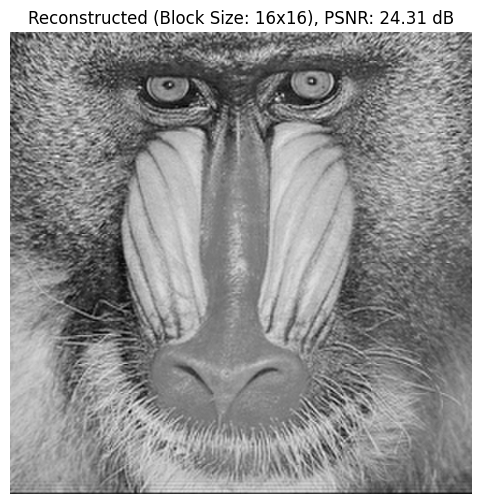

Block Size: 16x16
PSNR: 24.31 dB
Execution Time: 0.0695 seconds
------------------------------
--- Processing with block size: 64x64 ---


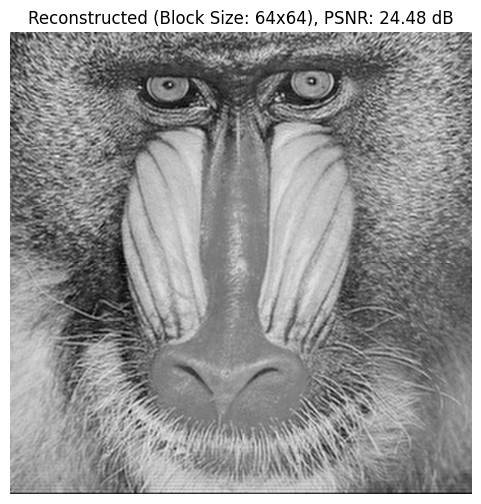

Block Size: 64x64
PSNR: 24.48 dB
Execution Time: 0.0080 seconds
------------------------------


--- Analysis: Block Size vs. PSNR and Execution Time ---
| Block Size | PSNR (dB) | Execution Time (s) |
|------------|-----------|--------------------|
| 8          | 24.09     | 0.2414             |
| 16         | 24.31     | 0.0695             |
| 64         | 24.48     | 0.0080             |


In [ ]:
if 'original_image_gray' not in globals() or original_image_gray is None:
    print("ERROR in image")
else:

    original_image_float_for_processing = original_image_gray.astype(np.float32)

    block_sizes_to_test = [8, 16, 64]
    block_processing_results = {}


    for N in block_sizes_to_test:
        print(f"--- Processing with block size: {N}x{N} ---")
        
        reconstructed_img, exec_time, psnr = process_image_blockwise(
            original_image_float_for_processing, 
            original_image_gray, 
            N
        )
        
        block_processing_results[N] = {
            'psnr': psnr,
            'time': exec_time,
            'image': reconstructed_img  
        }
        
        display_image(reconstructed_img, title=f"Reconstructed (Block Size: {N}x{N}), PSNR: {psnr:.2f} dB")
        print(f"Block Size: {N}x{N}")
        print(f"PSNR: {psnr:.2f} dB")
        print(f"Execution Time: {exec_time:.4f} seconds")
        print("-" * 30)

    
    print("\n\n--- Analysis: Block Size vs. PSNR and Execution Time ---")
    print("==========================================================")
    print("| Block Size | PSNR (dB) | Execution Time (s) |")
    print("|------------|-----------|--------------------|")
    for N in block_sizes_to_test:
        res = block_processing_results[N]
        print(f"| {N:<10} | {res['psnr']:<9.2f} | {res['time']:<18.4f} |")

# PART D

In [13]:
def dft2(block):
    return np.fft.fft2(block)

def idft2(block_dft_coeffs):
    return np.fft.ifft2(block_dft_coeffs)

In [14]:
def process_image_blockwise_dft(image_to_process_float, original_img_gray_for_psnr, block_size_N):
    original_rows, original_cols = image_to_process_float.shape
    
    pad_rows_bottom = (block_size_N - original_rows % block_size_N) % block_size_N
    pad_cols_right = (block_size_N - original_cols % block_size_N) % block_size_N
    padded_image = np.pad(image_to_process_float, 
                          ((0, pad_rows_bottom), (0, pad_cols_right)), 
                          mode='reflect')

    padded_rows, padded_cols = padded_image.shape
   
    reconstructed_padded_image_complex = np.zeros_like(padded_image, dtype=np.complex64) 

    mask_block = np.zeros((block_size_N, block_size_N), dtype=np.float32) 
    keep_dim = block_size_N // 2
    mask_block[0:keep_dim, 0:keep_dim] = 1.0
    
    start_time_proc = time.time()
    
    for r_idx in range(0, padded_rows, block_size_N):
        for c_idx in range(0, padded_cols, block_size_N):
            current_block = padded_image[r_idx : r_idx + block_size_N, c_idx : c_idx + block_size_N]
            
            block_dft_coeffs = dft2(current_block) 
            
            masked_block_dft_coeffs = block_dft_coeffs * mask_block

            reconstructed_block_complex = idft2(masked_block_dft_coeffs)

            reconstructed_padded_image_complex[r_idx : r_idx + block_size_N, c_idx : c_idx + block_size_N] = reconstructed_block_complex
            
    end_time_proc = time.time()
    execution_time_proc = end_time_proc - start_time_proc
    
    reconstructed_padded_image_real = np.real(reconstructed_padded_image_complex)
    
    reconstructed_image_cropped_float = reconstructed_padded_image_real[0:original_rows, 0:original_cols]
    
    reconstructed_image_uint8 = np.clip(reconstructed_image_cropped_float, 0, 255).astype(np.uint8)
    
    psnr_value = peak_signal_noise_ratio(original_img_gray_for_psnr, reconstructed_image_uint8, data_range=255)
    
    return reconstructed_image_uint8, execution_time_proc, psnr_value

Starting block-wise DFT processing for different block sizes...

--- Processing with DFT, block size: 8x8 ---


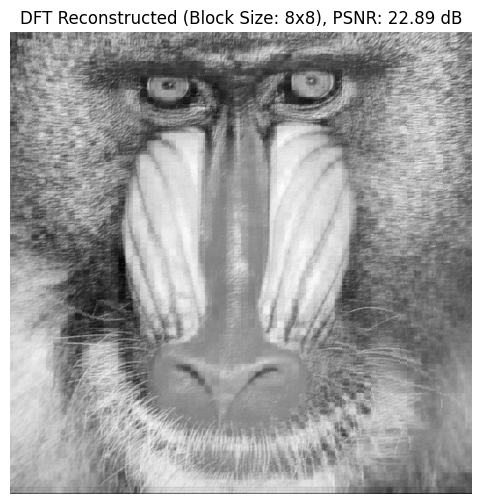

Block Size: 8x8
PSNR (DFT): 22.89 dB
Execution Time (DFT): 0.6884 seconds
------------------------------
--- Processing with DFT, block size: 16x16 ---


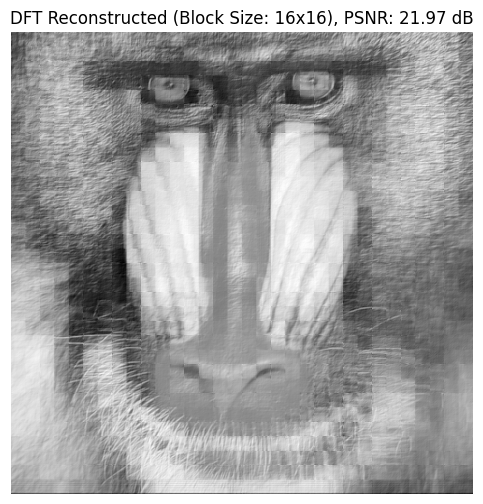

Block Size: 16x16
PSNR (DFT): 21.97 dB
Execution Time (DFT): 0.2131 seconds
------------------------------
--- Processing with DFT, block size: 64x64 ---


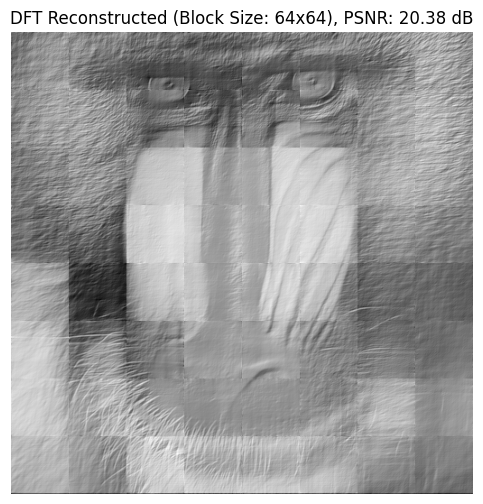

Block Size: 64x64
PSNR (DFT): 20.38 dB
Execution Time (DFT): 0.0300 seconds
------------------------------


--- Comparison: DFT vs DCT Block-Based Processing ---
| Block Size | PSNR (DFT) | Time (DFT) (s) | PSNR (DCT) | Time (DCT) (s) |
|------------|------------|----------------|------------|----------------|
| 8          | 22.89      | 0.6884         | 24.09      | 0.2414         |
| 16         | 21.97      | 0.2131         | 24.31      | 0.0695         |
| 64         | 20.38      | 0.0300         | 24.48      | 0.0080         |


In [ ]:
if 'original_image_gray' not in globals() or original_image_gray is None:
    print("ERROR in image")
elif 'block_processing_results' not in globals(): 
    print("Results from Part B  not found.")
else:
    original_image_float_for_processing = original_image_gray.astype(np.float32)

    block_sizes_to_test = [8, 16, 64]
    dft_block_processing_results = {}


    for N_dft in block_sizes_to_test:
        print(f"--- Processing with DFT, block size: {N_dft}x{N_dft} ---")
        
        reconstructed_img_dft, exec_time_dft, psnr_dft = process_image_blockwise_dft(
            original_image_float_for_processing, 
            original_image_gray,
            N_dft
        )
        
        dft_block_processing_results[N_dft] = {
            'psnr': psnr_dft,
            'time': exec_time_dft,
            'image': reconstructed_img_dft
        }
        
        display_image(reconstructed_img_dft, title=f"DFT Reconstructed (Block Size: {N_dft}x{N_dft}), PSNR: {psnr_dft:.2f} dB")
        print(f"Block Size: {N_dft}x{N_dft}")
        print(f"PSNR (DFT): {psnr_dft:.2f} dB")
        print(f"Execution Time (DFT): {exec_time_dft:.4f} seconds")
        print("-" * 30)

    print("\n\n--- Comparison: DFT vs DCT Block-Based Processing ---")
    print("===========================================================================")
    print("| Block Size | PSNR (DFT) | Time (DFT) (s) | PSNR (DCT) | Time (DCT) (s) |")
    print("|------------|------------|----------------|------------|----------------|")
    for N_comp in block_sizes_to_test:
        res_dft = dft_block_processing_results[N_comp]
        res_dct = block_processing_results[N_comp]
        print(f"| {N_comp:<10} | {res_dft['psnr']:<10.2f} | {res_dft['time']:<14.4f} | {res_dct['psnr']:<10.2f} | {res_dct['time']:<14.4f} |")